<center>
<h1>Fake news detection using graph neural network</h1>
<h2>SAGE GNN</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import torch
import pickle as pk
import torch.nn.functional as F

from torch.nn import Linear, LogSoftmax
from tool_box.upfd_dataset import ext_UPFD
from tool_box.GNN_train import plot_hist, train_all
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool

# Import datasets

In [2]:
datasets = pk.load(open('../data/datasets.pkl', 'rb'))

# Define the model

In [3]:
class SAGE(torch.nn.Module):
    
    
    def __init__(self, num_n_feature, num_g_feature, emb_size, num_layers=2):
        super(SAGE, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size
        
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            size_in = num_n_feature if i == 0 else emb_size
            self.convs.append(SAGEConv(size_in, emb_size))

        # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)


    
    def forward(self, x, edges_idx, batch_idx, g_features):
        for i, conv in enumerate(self.convs):
            x = conv(x, edges_idx)
            if i != len(self.convs) - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
            else:
                
                flatten = torch.cat([global_mean_pool(x, batch_idx),
                                     global_max_pool(x, batch_idx)], axis=1)

                if g_features.size()[-1]:
                    g_ft = self.lin_g(g_features)
                    flatten = torch.cat([flatten, g_ft], axis=1)

                out = self.act(self.out_layer(flatten))
                
        return out

# Training

In [4]:
models = train_all(SAGE, datasets, emb_size=100, epochs=100, lr=0.001, wd=0.01, batch_size=128)

--> Train on: origin


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.39  loss_val=0.44 | acc_train=0.86  acc_val=0.81
Epochs: 20 | loss_train=0.32  loss_val=0.4 | acc_train=0.87  acc_val=0.86
Epochs: 30 | loss_train=0.31  loss_val=0.4 | acc_train=0.87  acc_val=0.84
Epochs: 40 | loss_train=0.3  loss_val=0.43 | acc_train=0.89  acc_val=0.84
Epochs: 50 | loss_train=0.3  loss_val=0.41 | acc_train=0.87  acc_val=0.85
Epochs: 60 | loss_train=0.29  loss_val=0.51 | acc_train=0.88  acc_val=0.76
Epochs: 70 | loss_train=0.3  loss_val=0.42 | acc_train=0.88  acc_val=0.84
Epochs: 80 | loss_train=0.28  loss_val=0.57 | acc_train=0.88  acc_val=0.71
Epochs: 90 | loss_train=0.28  loss_val=0.52 | acc_train=0.88  acc_val=0.76
Epochs: 100 | loss_train=0.27  loss_val=0.57 | acc_train=0.89  acc_val=0.72
--> Train on: dataset1


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.51  loss_val=1.29 | acc_train=0.8  acc_val=0.51
Epochs: 20 | loss_train=0.48  loss_val=0.59 | acc_train=0.81  acc_val=0.63
Epochs: 30 | loss_train=0.54  loss_val=0.59 | acc_train=0.8  acc_val=0.66
Epochs: 40 | loss_train=0.52  loss_val=0.61 | acc_train=0.81  acc_val=0.79
Epochs: 50 | loss_train=0.46  loss_val=0.5 | acc_train=0.81  acc_val=0.78
Epochs: 60 | loss_train=0.47  loss_val=0.53 | acc_train=0.8  acc_val=0.71
Epochs: 70 | loss_train=0.47  loss_val=0.51 | acc_train=0.8  acc_val=0.8
Epochs: 80 | loss_train=0.42  loss_val=0.6 | acc_train=0.83  acc_val=0.79
Epochs: 90 | loss_train=0.42  loss_val=0.53 | acc_train=0.82  acc_val=0.79
Epochs: 100 | loss_train=0.46  loss_val=0.64 | acc_train=0.81  acc_val=0.78
--> Train on: dataset2


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.52  loss_val=0.99 | acc_train=0.8  acc_val=0.51
Epochs: 20 | loss_train=0.47  loss_val=0.57 | acc_train=0.81  acc_val=0.65
Epochs: 30 | loss_train=0.45  loss_val=0.59 | acc_train=0.83  acc_val=0.63
Epochs: 40 | loss_train=0.44  loss_val=0.5 | acc_train=0.81  acc_val=0.8
Epochs: 50 | loss_train=0.45  loss_val=0.55 | acc_train=0.81  acc_val=0.81
Epochs: 60 | loss_train=0.42  loss_val=0.52 | acc_train=0.83  acc_val=0.79
Epochs: 70 | loss_train=0.42  loss_val=0.48 | acc_train=0.83  acc_val=0.8
Epochs: 80 | loss_train=0.4  loss_val=0.46 | acc_train=0.84  acc_val=0.81
Epochs: 90 | loss_train=0.4  loss_val=0.52 | acc_train=0.84  acc_val=0.8
Epochs: 100 | loss_train=0.41  loss_val=0.65 | acc_train=0.82  acc_val=0.8


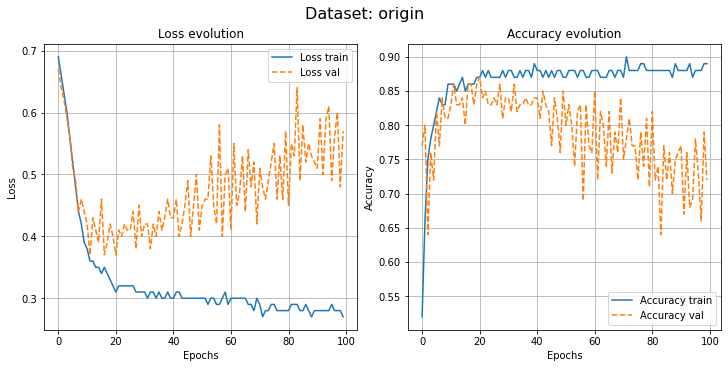

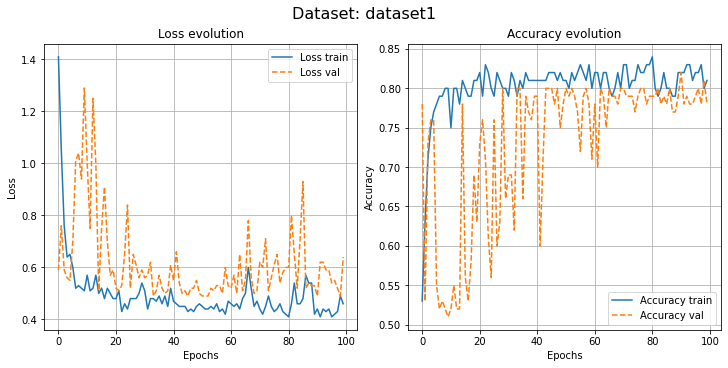

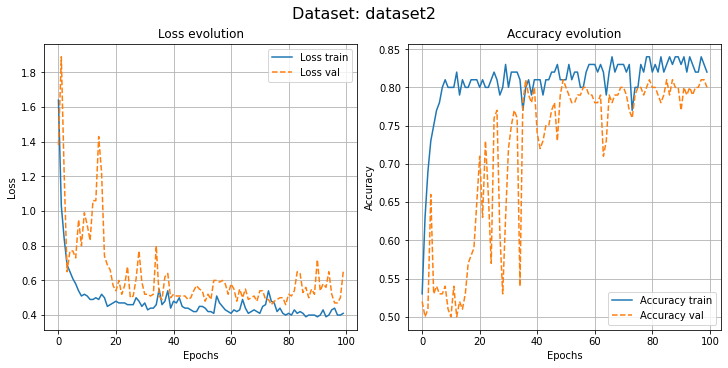

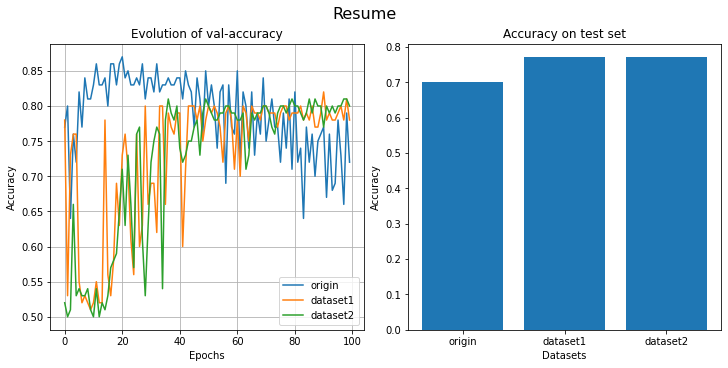

In [5]:
plot_hist(models)